In [ ]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import zeros, ones, flipud, log
from numpy.linalg import inv, eig, cholesky as chol
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error
import pickle as pkl
from tqdm import tqdm
from math import sqrt

In [ ]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
plt.style.use('seaborn-dark-palette')
plt.rcParams["mathtext.fontset"] = "cm"

In [ ]:
path = os.path.dirname(__file__)

In [ ]:
training_data = pd.read_csv(path+'/data/time_series_chamber.csv')

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:
def fit_base_ensemble(models, X_train, X_val, y_train, y_val):
    meta_X = list()
    for name, model in models:
        model.fit(X_train, y_train)
        yhat = model.predict(X_val)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
#     blender.fit(meta_X, y_val)
    return meta_X

def predict_base_ensemble(models, X_val):
    meta_X = list()
    for name, model in models:
        yhat = model.predict(X_val)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
    return meta_X

def fit_meta_ensemble(meta_X, y_val, meta_model):
    meta_model.fit(meta_X, y_val)
    return meta_model

def fit_full_ensemble(models, X_train, X_val, y_train, y_val, meta_model):
    meta = fit_base_ensemble(models, X_train, X_val, y_train, y_val)
    return fit_meta_ensemble(meta, y_val, meta_model)


def predict_ensemble(models, blender, X_test):
    meta_X = list()
    for name, model in models:
        yhat = model.predict(X_test)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
    return blender.predict(meta_X)

# ARIMA with first order differentiation

In [ ]:
#from ant_migration import *
import pandas as pd
import numpy as np
import math
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.arima.model import ARIMA

time series of chamber and plot the distribution

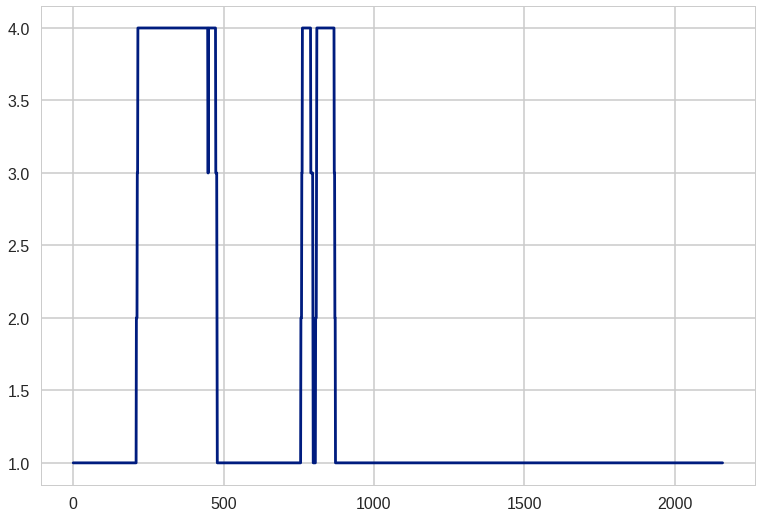

In [ ]:
#n, p = training_data.shape
#for i in range(1,p):

i = 13
autocorr_data = training_data['%i'%i].dropna().reset_index(drop=True)
autocorr_data = autocorr_data.iloc[0:math.floor(len(autocorr_data)*0.75)]
autocorr_data.plot()
plt.savefig(path+'/distribution_%i.png'%i)
plt.show()

ADF-test allows us to verify the stablity of time series. The original time series aren't stable, since the p-value 0.053010927518986325 > 0.05. Then we do the first-order differencing and the first-order differencing is stable, the p-value is quite small.

In [ ]:
ADF(autocorr_data)

(-2.9804644219433754,
 0.03675949231094873,
 26,
 2133,
 {'1%': -3.433419473570619,
  '5%': -2.862895974588963,
  '10%': -2.5674918550982277},
 -4099.9709515360855)

(-8.913511662100365,
 1.088181179922117e-14,
 25,
 2133,
 {'1%': -3.433419473570619,
  '5%': -2.862895974588963,
  '10%': -2.5674918550982277},
 -4090.044591921366)

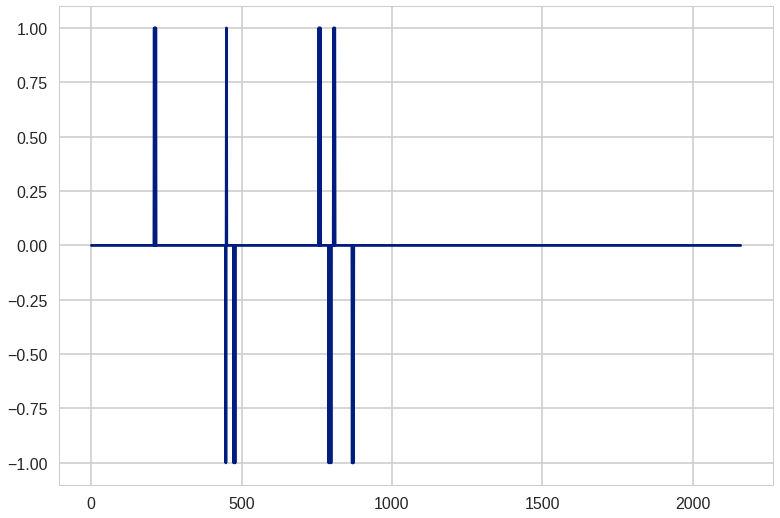

In [ ]:
d_data = autocorr_data.diff().dropna()
d_data.columns = ['first-order differencing']
d_data.plot()
ADF(d_data)

We do the acf and pacf in order to find out the appropriate order of ARIMA(p, d, q)

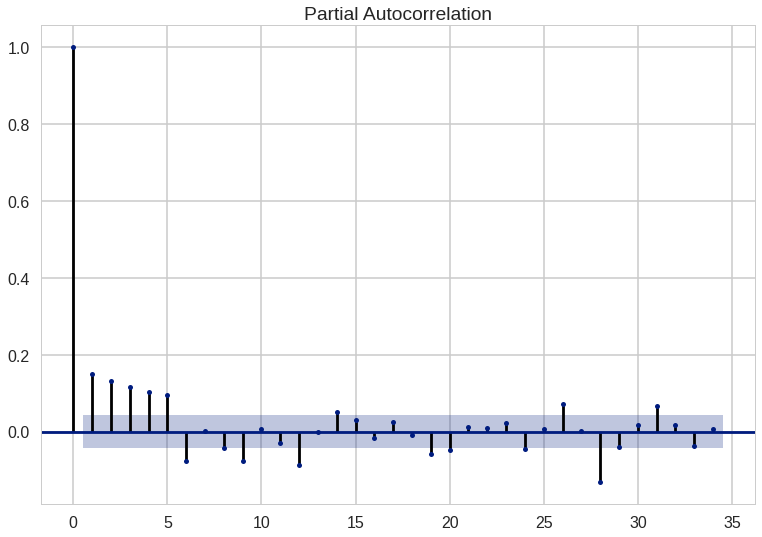

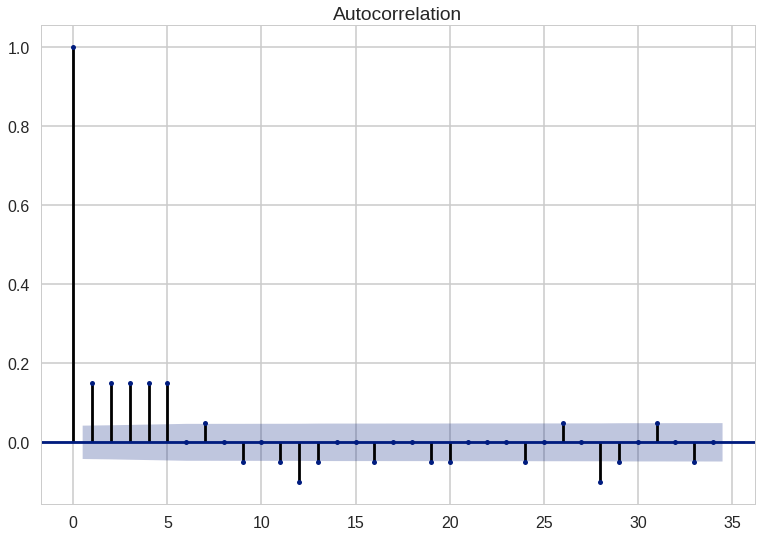

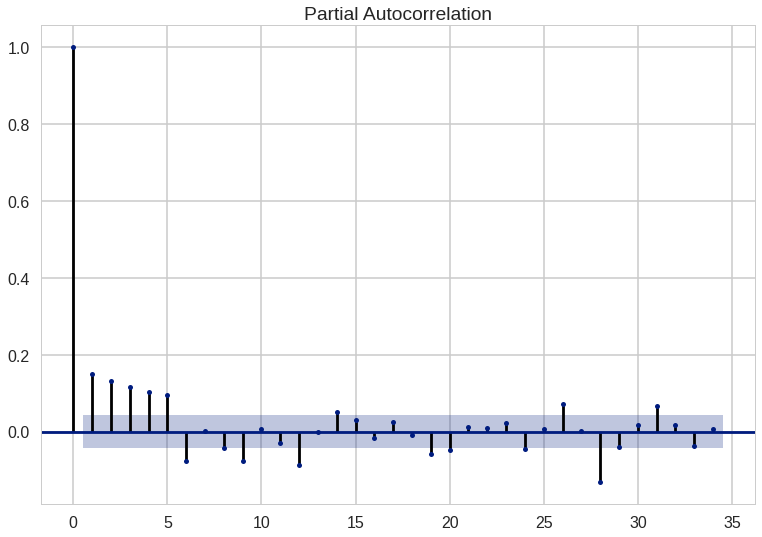

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(d_data)
plot_pacf(d_data)

In [ ]:
tmp = []
for p in range(5):
    for q in range(5):
        try:
            tmp.append([ARIMA(d_data, order = (p,1,q)).fit().bic, p, q])
        except:
            tmp.append([None, p, q])
tmp = pd.DataFrame(tmp,columns = ['bic', 'p', 'q'])
print(tmp)
tmp[tmp['bic'] == tmp['bic'].min()]

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


            bic  p  q
0  -2825.128699  0  0
1  -3967.695755  0  1
2  -3986.614355  0  2
3  -4006.235122  0  3
4  -4020.084085  0  4
5  -3437.981991  1  0
6  -3996.604775  1  1
7  -3956.789220  1  2
8  -3973.483853  1  3
9  -3998.801904  1  4
10 -3684.245280  2  0
11 -4026.203373  2  1
12 -3983.176555  2  2
13 -3963.389816  2  3
14 -3986.175711  2  4
15 -3815.648859  3  0
16 -4047.644654  3  1
17 -4018.969672  3  2
18 -3995.981984  3  3
19 -4036.019105  3  4
20 -3895.902503  4  0
21 -4063.357636  4  1
22 -4031.657141  4  2
23 -3986.745201  4  3
24 -3969.753434  4  4


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,bic,p,q
21,-4063.357636,4,1


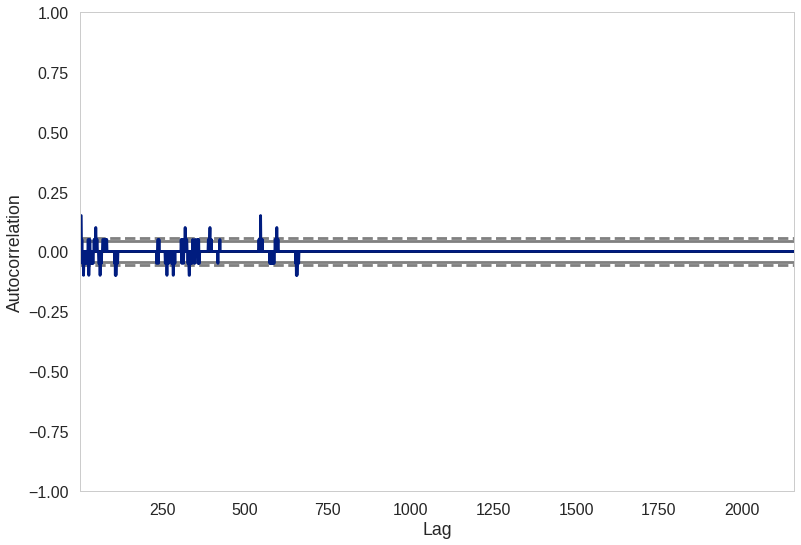

In [ ]:
#Check autocorrelation plot to determine best lag time for ARIMA
autocorrelation_plot(d_data)
plt.savefig(path+'/autocorrelation_%i.png'%i)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                     13   No. Observations:                 2159
Model:                 ARIMA(3, 1, 4)   Log Likelihood                2048.717
Date:                Fri, 23 Dec 2022   AIC                          -4081.435
Time:                        07:53:09   BIC                          -4036.019
Sample:                             0   HQIC                         -4064.823
                               - 2159                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9937      0.070    -14.160      0.000      -1.131      -0.856
ar.L2          0.5515      0.066      8.346      0.000       0.422       0.681
ar.L3          0.7242      0.047     15.563      0.0

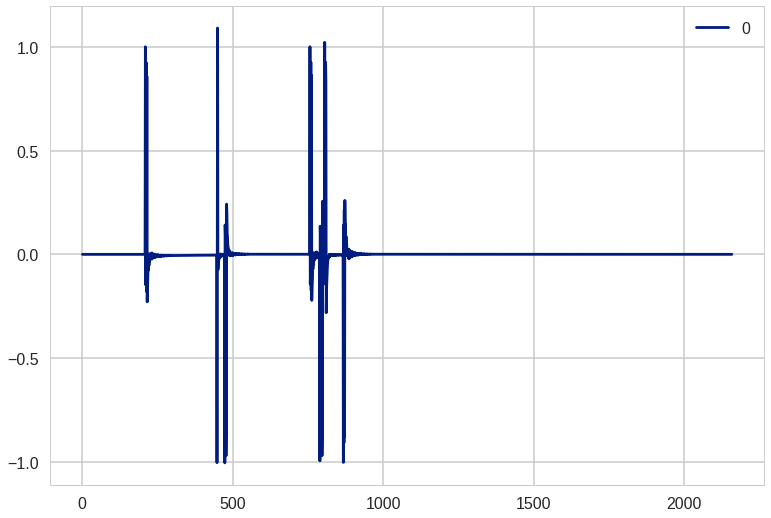

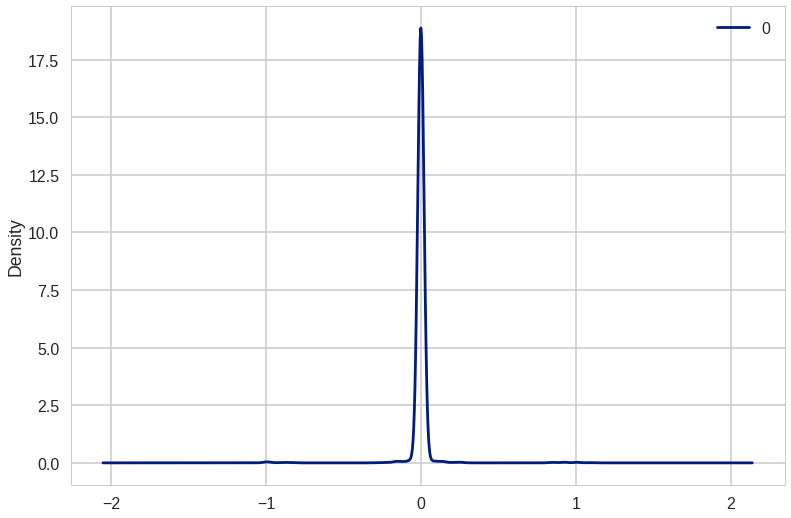

                 0
count  2159.000000
mean     -0.000497
std       0.093576
min      -1.004609
25%       0.000000
50%       0.000193
75%       0.000453
max       1.090789


In [ ]:
# def find_optimal_arima_lag
model = ARIMA(d_data, order=(3,1,4))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

In [ ]:
data = autocorr_data
ground_truth, start_t = data.to_numpy(), int(len(data) * 0.5)
predictions = list()

print("Predicting ARIMA with no thresholding")
for t_i in tqdm(range(len(data) - start_t)):
    current_t = t_i + start_t
    #threshold = 0
    #thresholds.append(threshold)
    model = ARIMA(data[t_i:current_t], order = (3,1,4))
    fitted_model = model.fit()
    prediction = fitted_model.forecast().reset_index(drop=True)
    predictions.append(prediction[0])


In [ ]:
def plot_time_series(ts_1, ts_label_1, ts_2, ts_label_2, title, path):
    assert len(ts_1) == len(ts_2)
    xs = list(range(0, len(ts_1)))

    plt.rcParams['savefig.dpi'] = 300 
    plt.rcParams['figure.dpi'] = 300
    
    plt.plot(xs, ts_2, c='red', label=ts_label_2, lw = 1.5)
    plt.plot(xs, ts_1, c='green', label=ts_label_1, lw = 1.5)

    plt.title(title)
    plt.legend(loc='upper left')
    plt.savefig(path)
    plt.show()

In [ ]:
plot_time_series(ts_1=predictions, ts_label_1='ARIMA Model', ts_2=data[start_t:], ts_label_2='Testing data', title='ARIMA predictions vs. truth', path = 'nb_arima.png')

# ARIMA without 1st order differentiation

In [ ]:
plot_acf(autocorr_data)
plot_pacf(autocorr_data)

In [ ]:
tmp = []
for p in range(5):
    for q in range(5):
        try:
            tmp.append([ARIMA(autocorr_data, order = (p,1,q)).fit().bic, p, q])
        except:
            tmp.append([None, p, q])
tmp = pd.DataFrame(tmp,columns = ['bic', 'p', 'q'])
print(tmp)
tmp[tmp['bic'] == tmp['bic'].min()]

In [ ]:
#Check autocorrelation plot to determine best lag time for ARIMA
autocorrelation_plot(autocorr_data)

In [ ]:
predictions = list()
print("Predicting ARIMA with no thresholding")

for t_i in tqdm(range(len(autocorr_data) - start_t)):

    current_t = t_i + start_t
    model = ARIMA(autocorr_data[t_i:current_t], order = (1,0,2))
    fitted_model = model.fit()
    
    prediction = fitted_model.forecast().reset_index(drop=True)
    predictions.append(prediction[0])

In [ ]:
print(len(predictions), len(autocorr_data[start_t:]))

In [ ]:
plot_time_series(ts_1=predictions, ts_label_1='Vanilla ARIMA Model', ts_2=autocorr_data[start_t:], ts_label_2='Close', title='ARIMA predictions vs. ground truth')


# Grid searching ARIMA parameters

In [ ]:
def evaluate_ARIMA_profit(data, order):
    num_days_year = 253
    ground_truth, start_t = data, int(num_days_year/2)
    assert len(data) > start_t

    predictions = list()
    thresholds = []
    training_X = data[:start_t].reset_index(drop=True)

    test_X = data[start_t:].reset_index(drop=True)

    for t_i in (range(len(data) - start_t)):
        current_t = t_i + start_t
        threshold = 0
        thresholds.append(threshold)
        model = ARIMA(data[:current_t], order = order)
        fitted_model = model.fit()
        prediction = fitted_model.forecast().reset_index(drop=True)
        predictions.append(prediction[0])

    balances_arima = simulate_trades_continuous(predictions, ground_truth[start_t:], thresholds)
    return balances_arima[len(balances_arima)-1]

def gridsearch_ARIMA(data, p_values, d_values, q_values):
    best_profit, best_order = -9999999, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                print(order)
                try:
                    balance = evaluate_ARIMA_profit(data, order)
                    if balance > best_profit:
                        best_profit, best_order = balance, order
                except:
                    continue
#     print('Best ARIMA%s Balance=%.3f' % (best_profit, best_order))
    return best_order

In [ ]:
first_df = training_data.loc["AAPL"].dropna()

data = first_df.reset_index(drop=True)

num_days_year = 253

ground_truth, start_t = first_df.to_numpy(), int(num_days_year/2)

predictions = list()
thresholds = []
training_X = data[:start_t].reset_index(drop=True)

test_X = data[start_t:].reset_index(drop=True)
p_values = [1, 5, 10, 25]
d_values = range(0, 2)
q_values = range(0, 2)
ideal_order = gridsearch_ARIMA(data[:start_t*2], p_values, d_values, q_values)


In [ ]:
print(ideal_order)